In [75]:
import os
import PIL.Image
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

In [2]:
os.listdir("/kaggle/input/yawn-eye-dataset-new/dataset_new/")

['test', 'train']

In [3]:
root_dir = f"/kaggle/input/yawn-eye-dataset-new/dataset_new"

In [4]:
categories = {'Closed' : 0, 'Open' : 1, 'yawn' : 2, 'no_yawn' : 3}

In [5]:
train_data_images = []
test_data_images = []
train_label_images = []
test_label_images = []

In [6]:
for cat in categories.keys():
    train_data_images.extend(os.listdir(f"{root_dir}/train/{cat}/"))
    train_label_images.extend([f"{cat}"]*(len(os.listdir(f"{root_dir}/train/{cat}/"))))    
    test_data_images.extend(os.listdir(f"{root_dir}/test/{cat}/"))
    test_label_images.extend([f"{cat}"]*(len(os.listdir(f"{root_dir}/test/{cat}/"))))    

In [7]:
len(train_data_images), len(train_label_images)

(2467, 2467)

In [8]:
len(test_data_images), len(test_label_images)

(433, 433)

In [76]:
class DrowsinessData(Dataset):
    def __init__(self, images, labels, categories, root_dir, is_train = True, transform = None):
        self.images = images
        self.labels = labels
        self.categories = categories
        self.is_train = is_train
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.is_train:
            image = f"{self.root_dir}/train/{label}/{image}"
        else:
            image = f"{self.root_dir}/test/{label}/{image}"
        #img = mpimg.imread(image)
        rgba_image = PIL.Image.open(image)
        img = rgba_image.convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.categories[label]

In [77]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((120, 120)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Grayscale(num_output_channels=1),
])

In [78]:
transform

Compose(
    ToTensor()
    Resize(size=(120, 120), interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    Grayscale(num_output_channels=1)
)

In [79]:
training_data = DrowsinessData(train_data_images, train_label_images, categories, root_dir = root_dir, is_train = True, transform = transform)
test_data = DrowsinessData(test_data_images, test_label_images, categories, root_dir = root_dir, is_train = False, transform = transform)

In [80]:
training_data[489]

(tensor([[[-6.0774e-02, -3.2280e-02,  7.7252e-02,  ..., -2.0507e-02,
           -4.4328e-04,  5.1317e-02],
          [-3.6201e-02, -8.1490e-02, -9.4430e-02,  ..., -3.5056e-03,
           -3.8977e-03,  1.8911e-02],
          [ 2.2294e-02,  5.1703e-02,  2.7196e-02,  ...,  1.9612e-02,
            1.6998e-02,  1.9285e-02],
          ...,
          [ 4.5771e-01,  4.5379e-01,  4.4987e-01,  ...,  3.8108e-01,
            3.7873e-01,  3.7873e-01],
          [ 4.5771e-01,  4.5379e-01,  4.4987e-01,  ...,  3.8108e-01,
            3.7873e-01,  3.7873e-01],
          [ 4.5771e-01,  4.5379e-01,  4.4987e-01,  ...,  3.8108e-01,
            3.7873e-01,  3.7873e-01]]]),
 0)

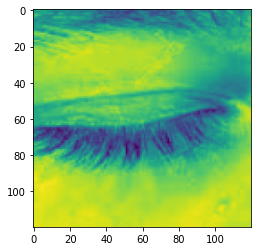

In [81]:
plt.imshow(training_data[489][0].permute(1, 2, 0))
plt.show()

In [82]:
batch_size = 8
learning_rate = 0.01
num_epochs = 10

In [83]:
train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [84]:
next(iter(train_dataloader))[0][0]

tensor([[[-0.7331, -0.7177, -0.6933,  ..., -0.4413, -0.4496, -0.4418],
         [-0.7026, -0.6905, -0.6776,  ..., -0.4496, -0.4435, -0.4418],
         [-0.6948, -0.6652, -0.6610,  ..., -0.4442, -0.4496, -0.4418],
         ...,
         [-0.3581, -0.3438, -0.3439,  ..., -0.4577, -0.4528, -0.4430],
         [-0.3516, -0.3516, -0.3444,  ..., -0.4442, -0.4459, -0.4453],
         [-0.3612, -0.3540, -0.3336,  ..., -0.4407, -0.4407, -0.4424]]])

In [93]:
class DrowsinessCNN(nn.Module):
    def __init__(self):
        super(DrowsinessCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 3)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 15, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(15*13*13, 300)
        self.fc2 = nn.Linear(300, 140)
        self.fc3 = nn.Linear(140, 4)
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        x = x.view(-1, 15*13*13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))
        return x

In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [101]:
model = DrowsinessCNN().to(device)

In [102]:
model

DrowsinessCNN(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2535, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=140, bias=True)
  (fc3): Linear(in_features=140, out_features=4, bias=True)
)

In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [104]:
n_total_steps = len(train_dataloader)
for epoch in tqdm(range(num_epochs)):
    for (images, labels) in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch+1}/{num_epochs} Loss : {loss.item():.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 1/10 Loss : 1.0097


  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 2/10 Loss : 0.2899


  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 3/10 Loss : 0.5629


  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 4/10 Loss : 0.6452


  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 5/10 Loss : 0.3775


  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 6/10 Loss : 0.2011


  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 7/10 Loss : 0.0997


  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 8/10 Loss : 0.2834


  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 9/10 Loss : 0.6370


  0%|          | 0/309 [00:00<?, ?it/s]

Epoch 10/10 Loss : 0.4373


In [105]:
model

DrowsinessCNN(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2535, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=140, bias=True)
  (fc3): Linear(in_features=140, out_features=4, bias=True)
)

In [106]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

In [107]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images,labels  in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
#         print(torch.max(outputs.data, 1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_data_images)} test images: {100 * correct // total} %')


Accuracy of the network on the 433 test images: 77 %


In [108]:
# labels.shape

In [109]:
# for img in tqdm(images):
#     model(img)
#     print(img.size())
#     plt.imshow(img.permute(1, 2, 0))
#     plt.show()

In [110]:
# images[0].size()

In [111]:
# cov1 = nn.Conv2d(1, 5, 3)
# cov2 = nn.Conv2d(5, 10, 3)
# cov3 = nn.Conv2d(10, 15, 3)
# pool = nn.MaxPool2d(2,2)
# fc = nn.Linear(15*13*13, 300)
# fc1 = nn.Linear(300, 140)
# fc2 = nn.Linear(140, 4)

In [112]:
# feature = next(iter(train_dataloader))[0][0]
# target = next(iter(train_dataloader))[1][0]
# x = cov1(feature)
# x = pool(x)
# x = cov2(x)
# x = pool(x)
# x = cov3(x)
# x = pool(x)
# x = x.view(-1, 15*13*13)
# x = fc(x)
# x = fc1(x)
# x = fc2(x)

In [113]:
# x, x.size()

In [115]:
# target.view(-1)

In [116]:
# criterion(x, target.view(-1))

In [297]:
# [torch.argmax(x)]

tensor(1)

In [302]:
# next(iter(train_dataloader))[1][0]

tensor(1)

In [117]:
# for img, lab in tqdm(train_dataloader):
#     print(img)

In [56]:
# training_data.err.shape

(98, 110, 4)